### Content Analysis Political Party
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("Topics_FB_Political_Posts_per_partyimmigration.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(855, 35)

In [5]:
posts['URL']

0      https://www.facebook.com/latinosvstrump/posts/...
1      https://www.facebook.com/latinosvstrump/posts/...
2      https://www.facebook.com/LatinosforJoe/posts/6...
3      https://www.facebook.com/Latinos4Biden/posts/1...
4      https://www.facebook.com/LatinosforJoe/posts/6...
                             ...                        
850    https://www.facebook.com/groups/16740326162334...
851    https://www.facebook.com/groups/16256741844186...
852    https://www.facebook.com/groups/16256741844186...
853    https://www.facebook.com/groups/16256741844186...
854    https://www.facebook.com/groups/16256741844186...
Name: URL, Length: 855, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [6]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [7]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [8]:
posts["Created"].head(5)

0    2020-09-23 18:45:31 EDT
1    2020-08-18 12:01:30 EDT
2    2020-10-13 21:14:57 EDT
3    2020-10-23 11:27:26 EDT
4    2020-09-18 19:16:01 EDT
Name: Created, dtype: object

In [9]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0     2020-09-23 18:45:31-04:00
1     2020-08-18 12:01:30-04:00
2     2020-10-13 21:14:57-04:00
3     2020-10-23 11:27:26-04:00
4     2020-09-18 19:16:01-04:00
                 ...           
850   2020-10-07 13:01:08-04:00
851   2020-10-21 02:39:39-04:00
852   2020-10-16 21:36:23-04:00
853   2020-09-06 13:04:54-04:00
854   2020-08-21 14:15:56-04:00
Name: converted_date, Length: 855, dtype: datetime64[ns, tzlocal()]

In [10]:
posts['converted_date'] = posts['converted_date'].dt.date

In [11]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date

,converted_date,count
0,2020-08-18,18
1,2020-08-19,8
2,2020-08-20,15
3,2020-08-21,12
4,2020-08-22,8
5,2020-08-23,4
6,2020-08-24,5
7,2020-08-25,11
8,2020-08-26,5
9,2020-08-27,4


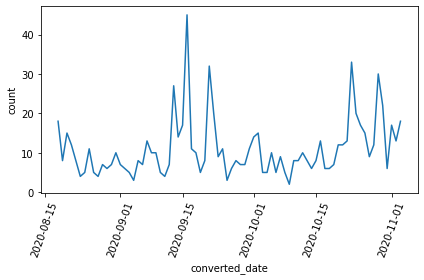

In [12]:
sns.lineplot(data=group_date, x='converted_date', y='count')

plt.xticks(rotation=70)
plt.tight_layout()

In [13]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date
324,358,DONALD TRUMP PARA HISPANOS,NaN,442514499638810,4842.0,2020-09-21 11:08:29 EDT,Photo,104,37,24,...,El poeta político.,“En carne viva”\n\n La batalla en aras a la...,NaN,NaN,193,2.3,Muy de acuerdo!!! “En carne viva”\n\n La ba...,Muy de acuerdo!!! “En carne viva”\n\n La ba...,Republican,2020-09-21


In [14]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [15]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [16]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [17]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
DONALD TRUMP PARA HISPANOS,102
Latinos For Trump -California Group,85
Mexicans for Donald Trump,60
Latinos Against Donald Trump,51
CARA - Cuban American Republican Alliance,45
Latinos For Trump.,28
Colombianos Y Latinoamericanos que apoyamos a Donald Trump,26
Republican National Hispanic Assembly of Virginia,22
Republican National Hispanic Assembly - Official Group,20


In [18]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (293, 36)
republicans (516, 36)
general politics (16, 36)
none (254,)


114

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [19]:
posts_democrats['MessageDescr'][3:6]

7    Check out Laura reppin' the Biden campaign! ME...
8    The old lines of the battle field have changed...
9    Even Fox News says a majority of Americans tru...
Name: MessageDescr, dtype: object

In [20]:
posts_democrats.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party', 'converted_date'],
      dtype='object')

## FB Groups Political Posts

## Tokenize words and Clean-up text

In [21]:
content = posts.copy()
content['MessageDescr']

0      Las DOS son el terror de los descerebrados. Un...
1      Algunas de las cosas que cuenta son realmente ...
2      The Biden campaign gets it. https://www.border...
3      There you go! That man lies, lies, lies. https...
4      Tech leaders supporting Biden. https://www.nyt...
5      Breaking News: Trump intentionally ordered tha...
6       A new report shows hundreds of cases in which...
7      Check out Laura reppin' the Biden campaign! ME...
8      The old lines of the battle field have changed...
9      Even Fox News says a majority of Americans tru...
10     Algunas de las cosas que cuenta son realmente ...
11     Interesting analysis regarding Roe v Wade as a...
12     545 niños siguen separados de sus padres. Esto...
13     Trump has been devastating to the Hispanic com...
14     https://nowthisnews.com/politics/give-me-a-fck...
15     About 8,800 unaccompanied children have been q...
16      Spend some time with Senator Kamala Harris as...
17     A petición de México el 

In [22]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(855,)

In [23]:
# Convert to list
data = content.cleanMessage.tolist()

In [24]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['las', 'dos', 'son', 'el', 'terror', 'de', 'los', 'descerebrados', 'una', 'ya', 'va', 'de', 'retirada', 'pero', 'le', 'otra', 'les', 'va', 'dar', 'dolores', 'de', 'cabeza', 'por', 'muchos', 'anos', 'en', 'todas', 'las', 'epocas', 'cada', 'generacion', 'siempre', 'tiene', 'uno', 'varios', 'monstruos', 'que', 'enfrentar', 'para', 'los', 'republicanos', 'de', 'nuestros', 'tiempos', 'su', 'gran', 'fantasma', 'es', 'el', 'comunismo', 'que', 'no', 'tienen', 'ni', 'idea', 'de', 'que', 'es', 'pero', 'le', 'cuelgan', 'la', 'etiqueta', 'todo', 'lo', 'que', 'contradiga', 'sus', 'intereses', 'estupidos', 'pensamientos', 'el', 'muro', 'contra', 'el', 'que', 'se', 'estrellan', 'las', 'aberraciones', 'republicanas', 'tiene', 'dos', 'nombres', 'son', 'de', 'mujer'], ['algunas', 'de', 'las', 'cosas', 'que', 'cuenta', 'son', 'realmente', 'aterradoras', 'como', 'eso', 'de', 'afilar', 'los', 'postes', 'de', 'su', 'muro', 'para', 'que', 'danen', 'mas', 'un', 'ex', 'alto', 'funcionario', 'esta', 'dando', 

#### Creating Bigram and Trigram Models

In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['las', 'dos', 'son', 'el', 'terror', 'de', 'los', 'descerebrados', 'una', 'ya', 'va', 'de', 'retirada', 'pero', 'le', 'otra', 'les', 'va', 'dar', 'dolores', 'de', 'cabeza', 'por', 'muchos', 'anos', 'en', 'todas', 'las', 'epocas', 'cada', 'generacion', 'siempre', 'tiene', 'uno', 'varios', 'monstruos', 'que', 'enfrentar', 'para', 'los', 'republicanos', 'de', 'nuestros', 'tiempos', 'su', 'gran', 'fantasma', 'es', 'el', 'comunismo', 'que', 'no', 'tienen', 'ni', 'idea', 'de', 'que', 'es', 'pero', 'le', 'cuelgan', 'la', 'etiqueta', 'todo', 'lo', 'que', 'contradiga', 'sus', 'intereses', 'estupidos', 'pensamientos', 'el', 'muro', 'contra', 'el', 'que', 'se', 'estrellan', 'las', 'aberraciones', 'republicanas', 'tiene', 'dos', 'nombres', 'son', 'de', 'mujer']


## Remove Stopwords, Make Bigrams and Lemmatize

In [27]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [28]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [30]:
print(data_words_nostops[1:2])

[['cosas', 'cuenta', 'realmente', 'aterradoras', 'afilar', 'postes', 'muro', 'danen', 'alto', 'funcionario', 'dando', 'voz', 'alarma', 'uso', 'indebido', 'peligroso', 'trump', 'agencia', 'jefe', 'personal', 'dhs', 'afirma', 'trump', 'trato', 'usar', 'habilidades', 'magicas', 'excusar', 'acciones', 'ilegales']]


## Bag of Words

In [31]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [32]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [33]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [34]:
final_dict.most_common(1000)

[('trump', 926),
 ('president / presidente', 248),
 ('votar', 216),
 ('american / america / americans', 213),
 ('hacer', 156),
 ('mexico', 130),
 ('gustar', 117),
 ('personar', 116),
 ('decir', 114),
 ('country', 111),
 ('ano', 102),
 ('border', 85),
 ('frontero', 83),
 ('medio', 81),
 ('partir', 80),
 ('unir', 77),
 ('ninos', 75),
 ('nuevo', 71),
 ('also', 67),
 ('usar', 64),
 ('national', 64),
 ('democrats', 61),
 ('politica', 60),
 ('ley', 60),
 ('tratar', 58),
 ('ahora', 58),
 ('solo', 57),
 ('vida', 57),
 ('familia', 56),
 ('creer', 56),
 ('libertar', 56),
 ('trabajar', 55),
 ('ser', 54),
 ('querer', 54),
 ('ver', 54),
 ('hoy', 53),
 ('donar', 53),
 ('dar', 51),
 ('poder', 51),
 ('covid / coronavirus', 50),
 ('political', 49),
 ('millón', 48),
 ('apoyar', 48),
 ('gran', 47),
 ('padre', 47),
 ('criminal', 47),
 ('democratas', 47),
 ('socialista', 47),
 ('izquierdo', 47),
 ('mal', 45),
 ('murar', 44),
 ('guerra', 44),
 ('pasar', 43),
 ('inmigrante', 43),
 ('defender', 43),
 ('ir', 4

In [35]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [36]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
print(bow_df)

     abajar  abanderar  abandonar  abarrotar  abel  aberración  abide  \
0         0          0          0          0     0           1      0   
1         0          0          0          0     0           0      0   
2         0          0          0          0     0           0      0   
3         0          0          0          0     0           0      0   
4         0          0          0          0     0           0      0   
5         0          0          0          0     0           0      0   
6         0          0          0          0     0           0      0   
7         0          0          0          0     0           0      0   
8         0          0          0          0     0           0      0   
9         0          0          0          0     0           0      0   
10        0          0          0          0     0           0      0   
11        0          0          0          0     0           0      0   
12        0          0          0          0     0 

In [37]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [38]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,1.983949
america,2.817796
presidente,3.230482
country,3.263634
border,3.333430
votar,3.345551
mexico,3.475604
hacer,3.489590
personar,3.503775
medio,3.657926


In [39]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [40]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [41]:
df

,tfidf
aberración,0.227684
ano,0.130069
comunismo,0.174971
contradecir,0.227684
dar,0.135016
descerebrado,0.227684
dolor,0.217839
enfrentar,0.159504
epocas,0.227684
estupidos,0.227684


In [42]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,te gustaría dejar de ignorar de una vez por t...,5
1,the canadian news media is notoriously left wi...,4
2,cada día parece que descubrimos nuevos horror...,4
3,"su postura sobre la inmigración, el compromis...",4
4,chameleon kamala’s mission of dispair\nby ped...,3
5,“quienes deben votar por trump?”\n\n si ...,3
6,yo no voy a votar por trump ...\npor jackie d...,3
7,"""como barack obama no alcanzó a destruir este...",2
8,"!!!!breaking news!!!\n\nthe mexican customs, ...",2
9,las dos son el terror de los descerebrados. un...,2


### Repeated messages

In [43]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

results.to_csv("mostpopularNewsMedia.csv")

In [44]:
results.sort_values(by='Counts',ascending=False)

Counts  \
MessageDescr                                       Link                                                         
 Join us for our next show with special guest @... https://www.facebook.com/Thetruenewsnetwork/vid...      22   
 Since 2016, Julio de Lima Silva, originally fr... https://www.facebook.com/RealLft2020/videos/358...      18   
 #Repost @wearemimiandvane\n・・・\nJoin us for ou... https://www.facebook.com/marcogutierrezshow/vid...      17   
 Proclamation on National Hispanic Heritage Mon... https://www.facebook.com/119502916558014/videos...      14   
 Don’t lie Joe Biden, this is the truth about c... https://www.facebook.com/OscarElBlue/videos/395...       7   
 Te gustaría dejar de ignorar de una vez por to... https://www.facebook.com/losignorantestv/videos...       5   
 Cada día parece que descubrimos nuevos horrore... https://www.facebook.com/7860876103/posts/10157...       4   
 Su postura sobre la inmigración, el compromiso... https://www.diariolasamericas.com/america-latin...       4   
The Canadian news media is notoriously left win... https://www.facebook.com/100002161841726/posts/...       4   
 CHAMELEON KAMALA’S MISSION OF DISPAIR\nby Pedr... https://www.facebook.com/photo.php?fbid=2748552...       3   
 Me rolling into the voting booths choosing;\n#... https://www.facebook.com/freddysanchezzz/videos...       3   
 Do you know Alexander Hamilton? Would you like... https://www.facebook.com/laalternativaverdadera...       3   
 Breaking Campaign News. Jeffi Grigenti has rec... https://www.facebook.com/photo.php?fbid=1015896...       3   
 “Quienes deben votar por Trump?”\n\n      Si u... https://www.facebook.com/poetapolitico/photos/a...       3   
 We are fighting for economic freedom and oppor... https://www.facebook.com/photo.php?fbid=2579508...       3   
 QUERIDOS PATRIOTAS:\n\nEste video lo tenemos q... https://www.facebook.com/groups/918054358526588...       3   
Tonight! 🇺🇸❤️🙏🏼 Hoy en el programa “Esto No Tie... https://www.facebook.com/photo.php?fbid=1022437...       3   
///urgent-environmentalist-ambientalista** /FOR... https://www.elchubut.com.ar/                             3   
 YO NO VOY A VOTAR POR TRUMP ...\nPor Jackie De... https://www.facebook.com/photo.php?fbid=4424801...       3   
 The arrest of General Cienfuegos/ Trump speaks... https://www.facebook.com/OscarElBlue/videos/978...       3   
 Para los que piensan que El PRESIDENTE DE LOS ... https://www.facebook.com/Marlenegomezconmundosi...       2   
 Still love my democrat friends and family but.... https://www.facebook.com/250401089161721/posts/...       2   
 "To my liberal/democrat friends". Received thi... https://www.facebook.com/100000108307822/posts/...       2   
 What is a coyote or pollero? For all you liber... https://www.facebook.com/OscarElBlue/videos/358...       2   
In the weeks to come leading up to Election 202... https://www.westernjournal.com/op-ed-catholic-d...       2   
DIEGO MARTINEZ FOR GOVERNOR 2022!! Please donat... https://www.facebook.com/diegomartinezforgovern...       2   
 Cards in the Mirror, by Armando de Armas: "Eve... https://www.facebook.com/photo.php?fbid=3637347...       2   
DIEGO MARTINEZ FOR GOVERNOR 2022!! Please donat... https://www.facebook.com/diegomartinezforgovern...       2   
Sigue con sus mentiras. Esas jaulas fueron crea... https://www.nytimes.com/2020/10/21/us/migrant-c...       2   
 THIS JUST IN:  The Republican National Hispani... https://www.facebook.com/907926642626688/posts/...       2   
 Our voices will be heard:\nRacist 45 will cont... https://www.facebook.com/photo.php?fbid=2556262...       2   
 CHAMELEON KAMALA’s  & LECHEROUS JOE's MISSION ... https://www.facebook.com/photo.php?fbid=2770018...       2   
 Vicente Gonzalez exposed - clearly detached fr... https://www.facebook.com/250575432616643/videos...       2   
 Por Armando de Armas.   Acabo de descubrir en ... https://zoepost.com/bajo-el-garapacho-del-cangr...       2   
 "Como Barack Obama no alcanzó a de

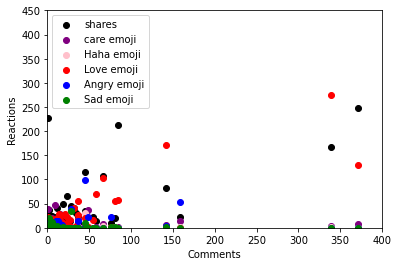

In [45]:
results.reset_index()
plt.xlim(0,400)
plt.ylim(0,450)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


In [46]:
#Topic Modeling
#Create the Dictionary and Corpus needed for Topic Modeling


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]
#Buiding the Topic Model

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1)]]


[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]

In [47]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [48]:
#View the topics in LDA model
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.064*"presidente" + 0.038*"ninos" + 0.037*"frontero" + 0.031*"nuevo" + '
  '0.030*"trump" + 0.024*"politica" + 0.024*"solo" + 0.023*"unir" + '
  '0.022*"partir" + 0.021*"ver"'),
 (1,
  '0.112*"director" + 0.067*"people" + 0.050*"personal" + 0.040*"contar" + '
  '0.026*"realmente" + 0.022*"periodista" + 0.022*"often" + 0.008*"habilidad" '
  '+ 0.006*"prensar" + 0.002*"serie"'),
 (2,
  '0.606*"trump" + 0.047*"democrats" + 0.031*"america" + 0.028*"agree" + '
  '0.024*"legal" + 0.017*"nuclear" + 0.011*"talk" + 0.008*"official" + '
  '0.008*"latinosfortrump" + 0.004*"moral"'),
 (3,
  '0.116*"gustar" + 0.044*"tratar" + 0.035*"guerra" + 0.029*"mayor" + '
  '0.022*"llevar" + 0.021*"ano" + 0.021*"murar" + 0.020*"traficar" + '
  '0.019*"producir" + 0.018*"virus"'),
 (4,
  '0.074*"dangerous" + 0.055*"social" + 0.054*"take" + 0.052*"states" + '
  '0.031*"make" + 0.030*"college" + 0.029*"made" + 0.020*"defense" + '
  '0.020*"provide" + 0.018*"virus"'),
 (5,
  '0.197*"border" + 0.047*"speci

In [49]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -18.073421665521995

Coherence Score:  0.4440892527300516


In [50]:
#Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.305446 -0.005245       1        1  19.378290
14    -0.217846 -0.150436       2        1  14.140720
3     -0.234858 -0.168984       3        1  12.447571
12    -0.099992  0.279937       4        1  11.064092
2     -0.131354  0.216787       5        1   9.084592
18    -0.011611  0.030409       6        1   7.325603
9     -0.009608 -0.041409       7        1   7.252799
15     0.032533  0.100232       8        1   4.309225
7      0.056531 -0.031927       9        1   3.808680
4      0.080671 -0.022754      10        1   2.023983
6      0.074766 -0.033996      11        1   1.723967
8      0.081312 -0.020577      12        1   1.583776
1      0.087988 -0.018855      13        1   1.309883
17     0.087578 -0.020297      14        1   1.153578
5      0.087499 -0.019961      15        1   0.956578
11     0.087396 -0.019752      16        1   0.890621
13     0.087785 -0.020783      17        1   0.761409
10     0.086366 -0.017800      18        1   0.576018
16     0.081167 -0.017594      19        1   0.140369
19     0.079124 -0.016994      20        1   0.068253, topic_info=                         Term         Freq        Total Category  logprob  \
45                      trump  1522.000000  1522.000000  Default  30.0000   
446                    gustar   357.000000   357.000000  Default  29.0000   
63                    america   431.000000   431.000000  Default  28.0000   
118                     decir   223.000000   223.000000  Default  27.0000   
154                     votar   325.000000   325.000000  Default  26.0000   
114                   country   254.000000   254.000000  Default  25.0000   
89                     mexico   210.000000   210.000000  Default  24.0000   
320                     hacer   331.000000   331.000000  Default  23.0000   
142                presidente   397.000000   397.000000  Default  22.0000   
139                  personar   294.000000   294.000000  Default  21.0000   
229                      also   140.000000   140.000000  Default  20.0000   
301                 president    69.000000    69.000000  Default  19.0000   
83                      ninos   184.000000   184.000000  Default  18.0000   
179                  frontero   179.000000   179.000000  Default  17.0000   
303                  criminal    81.000000    81.000000  Default  16.0000   
115                     creer   103.000000   103.000000  Default  15.0000   
332                  possible    61.000000    61.000000  Default  14.0000   
44                     tratar   153.000000   153.000000  Default  13.0000   
582                     ahora   138.000000   138.000000  Default  12.0000   
267                 democrats   107.000000   107.000000  Default  11.0000   
608            estadounidense   135.000000   135.000000  Default  10.0000   
113                   control    51.000000    51.000000  Default   9.0000   
13                       gran    90.000000    90.000000  Default   8.0000   
52                     border    47.000000    47.000000  Default   7.0000   
344                     vivir    83.000000    83.000000  Default   6.0000   
445                    guerra   108.000000   108.000000  Default   5.0000   
238                    crisis   101.000000   101.000000  Default   4.0000   
397                      vida   114.000000   114.000000  Default   3.0000   
396                socialista    63.000000    63.000000  Default   2.0000   
557                 izquierdo    68.000000    68.000000  Default   1.0000   
83                      ninos   183.154144   184.244339   Topic1  -3.2663   
179                  frontero   178.701874   179.792068   Topic1  -3.2909   
194                  politica   117.208076   118.298233   Topic1  -3.7127   
197                      solo   116.079041   117.169197   Topic1  -3.7223   
580                       ver   101.513428   102.603584   Topic1  -3.8564 

## Building LDA Mallet Model

In [51]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [52]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('frontero', 0.038273615635179156),
   ('migrante', 0.021172638436482084),
   ('gente', 0.02035830618892508),
   ('despues', 0.019543973941368076),
   ('legal', 0.018729641693811076),
   ('ninos', 0.01710097719869707),
   ('ser', 0.01710097719869707),
   ('comunidad', 0.016286644951140065),
   ('personar', 0.016286644951140065),
   ('politica', 0.016286644951140065)]),
 (7,
  [('democratas', 0.02109375),
   ('apoyar', 0.01953125),
   ('familia', 0.01484375),
   ('chino', 0.0140625),
   ('politica', 0.0140625),
   ('americano', 0.0140625),
   ('equipar', 0.01328125),
   ('dar', 0.0125),
   ('pasar', 0.0125),
   ('virus', 0.01171875)]),
 (4,
  [('unir', 0.03321799307958478),
   ('nuevo', 0.02698961937716263),
   ('tambien', 0.023529411764705882),
   ('mundial', 0.021453287197231833),
   ('estadounidense', 0.019377162629757784),
   ('historia', 0.017993079584775088),
   ('hombre', 0.01591695501730104),
   ('proteger', 0.01453287197231834),
   ('liderar', 0.01453287197231834),
   

## Finding the optimal number of topics for LDA

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [61]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=2)

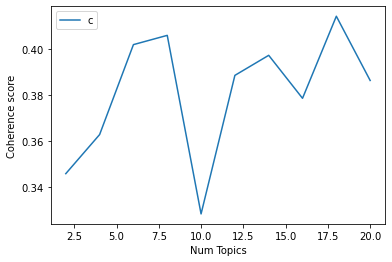

In [62]:
# Show graph
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [63]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.346
Num Topics = 4  has Coherence Value of 0.3629
Num Topics = 6  has Coherence Value of 0.4019
Num Topics = 8  has Coherence Value of 0.406
Num Topics = 10  has Coherence Value of 0.3285
Num Topics = 12  has Coherence Value of 0.3886
Num Topics = 14  has Coherence Value of 0.3973
Num Topics = 16  has Coherence Value of 0.3786
Num Topics = 18  has Coherence Value of 0.4142
Num Topics = 20  has Coherence Value of 0.3864


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

## Finding the dominant topic in each sentence

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

## Find the most representative document for each topic

In [ ]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

In [ ]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [ ]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics